In [33]:

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

np.random.seed(164)

%run ./CentralizedLunarKF.ipynb

**Pre-defined values from Lunar Time-Transfer paper to define Q and R**

In [34]:
# constant terms, given in Bhamidipati et. al
T_c = 0.00000009775
f_L1 = 1575420000
N_i = 4
CN0 = 15
B_pll = 0.5
B_fe = 26000000
T = 0.020
d = 0.3
pi = math.pi
c = 299792458
B_dll = 0.5

s_dll = (B_dll/(2*CN0))*(1/(T_c*B_fe))*(1+(1/(T*CN0))) # Equation (22)
pr_var = ((c*T_c)**2)*s_dll # pseudorange variance

s_pll = (B_pll/(CN0))*(1+(1/(2*T*CN0))) # Equation (33)
prr_var = ((c**2)/((2*pi*f_L1 * T_c)**2)) * (s_pll) # pseudorange rate variance


# Assuming 2 satellites, R is the measurement noise covariance matrix
R = np.array([[pr_var,0,0,0],[0,pr_var,0,0],[0,0,prr_var,0],[0,0,0,prr_var]])

if __name__ == '__main__':
    print(R)

[[2.44036996e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.44036996e+01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.53302279e+09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.53302279e+09]]


In [35]:
# more constant terms, pertinent to Q matrix
# Q is process noise covariance matrix
h_0 = 1.4*(10**(-22))
h_m1 = 2.3*(10**(-26))
h_m2 = 3.3*(10**(-31))

dt = 60

e1 = (h_0/2)*dt + 2*h_m1*(dt*dt) + (2/3)*((pi*h_m2*dt)**2)*dt
e2 = h_m1*dt + h_m2*(pi*dt)**2
e3 = (h_0/(2*dt))+ 4*h_m1 + (8/3)*(pi*pi)*h_m2*dt

Q = np.array([[e1,e2],[e2,e3]])

if __name__ == '__main__':
    print(Q)

[[4.36560000e-21 1.39172509e-24]
 [1.39172509e-24 1.25918778e-24]]


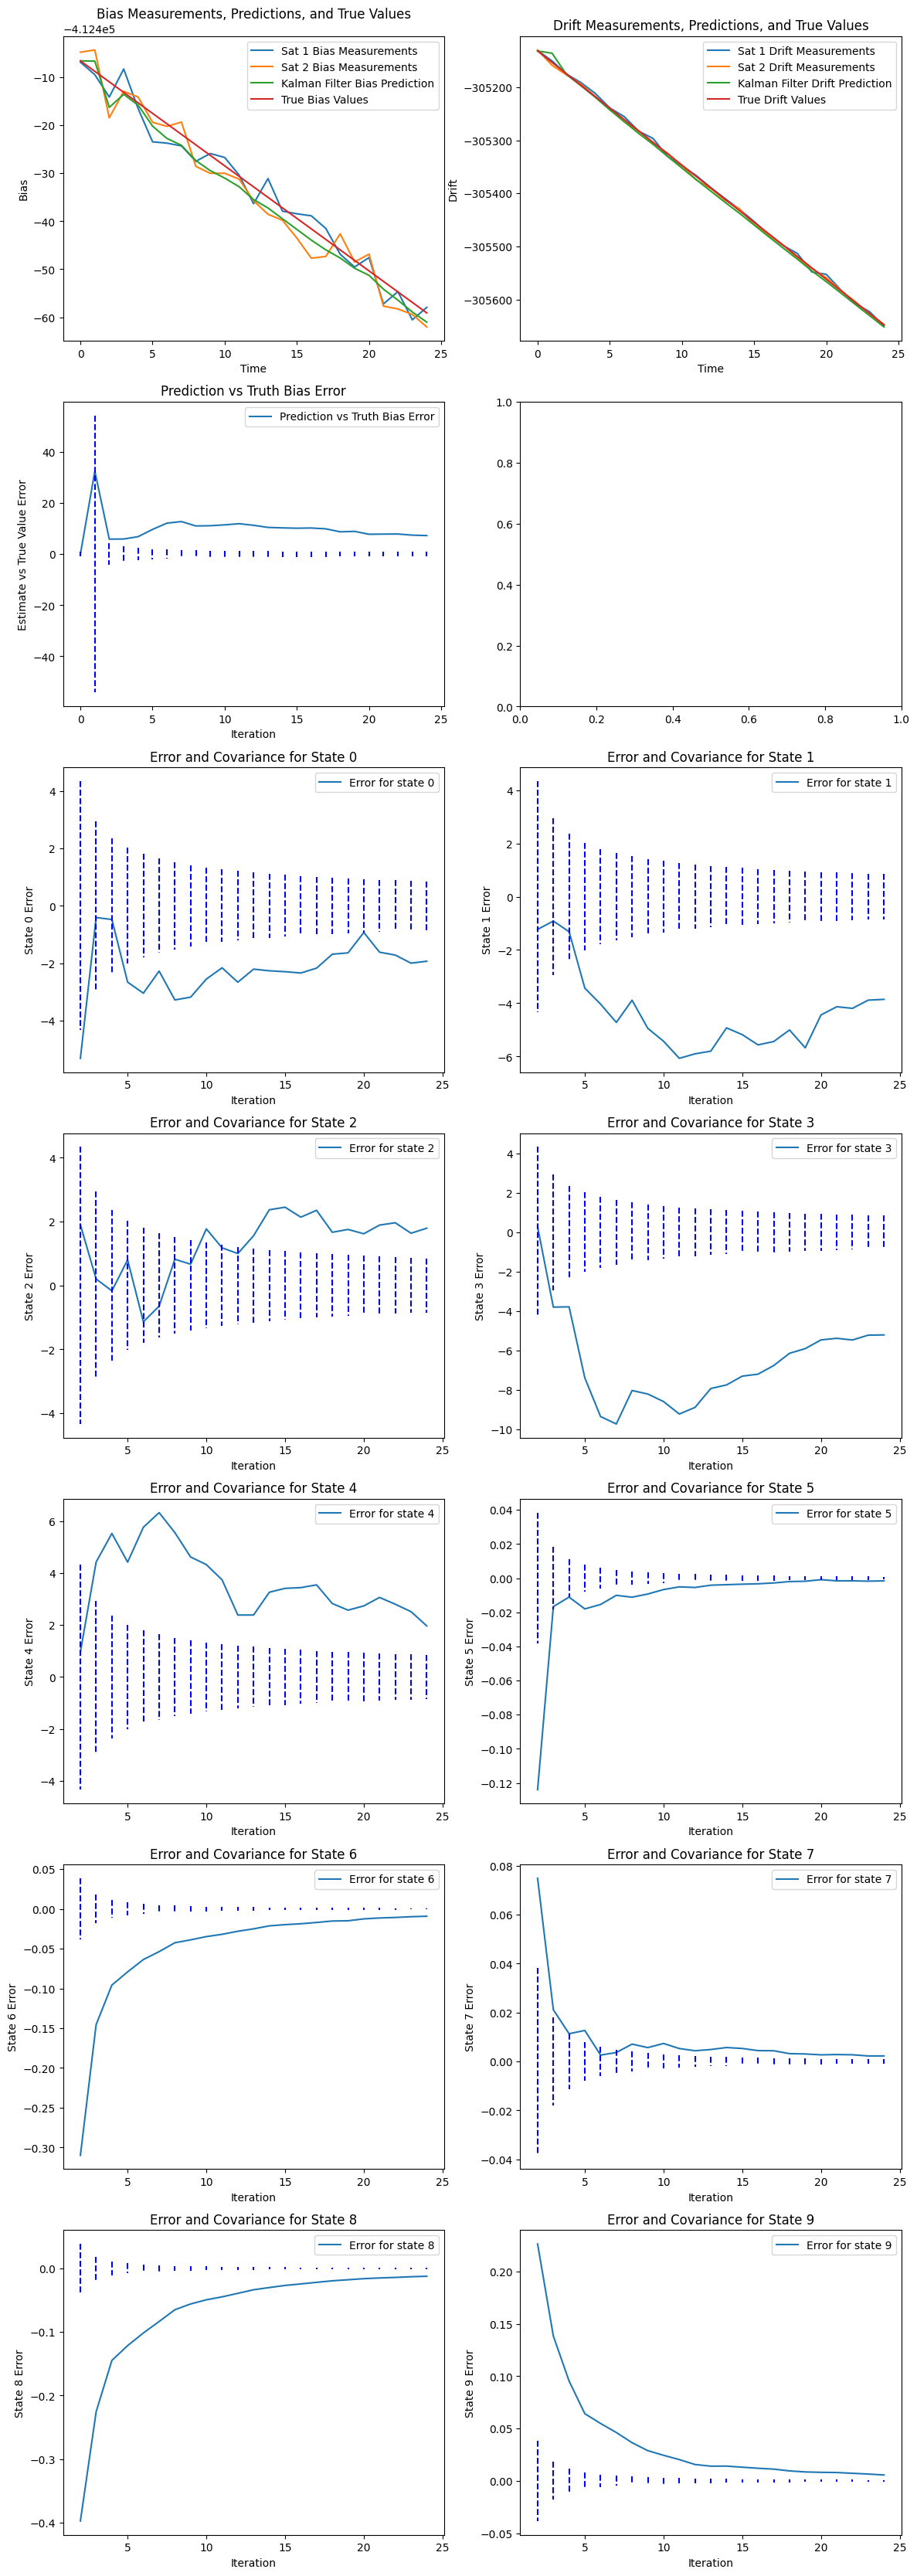

In [36]:
def example():
    C = np.array([[0.2,0.2,0.2,0.2,0.2], [0.5, 0.5, 0, 0,0], [0.5, 0, 0.5, 0,0], [0.5,0,0, 0.5,0],[0.5,0,0,0,0.5]])
    c = 299792458

    iterations = 25

    A = np.array([  [1,0,0,0,0,dt,0,0,0,0],
                    [0,1,0,0,0,0,dt,0,0,0],
                    [0,0,1,0,0,0,0,dt,0,0],
                    [0,0,0,1,0,0,0,0,dt,0],
                    [0,0,0,0,1,0,0,0,0,dt],
                    [0,0,0,0,0,1,0,0,0,0],
                    [0,0,0,0,0,0,1,0,0,0],
                    [0,0,0,0,0,0,0,1,0,0],
                    [0,0,0,0,0,0,0,0,1,0],
                    [0,0,0,0,0,0,0,0,0,1]])

    R = lambda N :9*np.eye(2*N,2*N)
    Q = np.array([[1.30877395*(10**-12), 4.17228686*(10**-16)],
    [4.17228686*(10**-16), 3.77495000*(10**-16)]])

    n = len(C[0])
    true_biases = np.array([[np.random.normal(0,10**(-3)) for _ in range(n)]]).T
    true_drifts = np.array([[np.random.normal(0,10**(-9)) for _ in range(n)]]).T

    x = c*np.vstack((true_biases,true_drifts))

    # random initial estimates for each node

    x0 = np.copy(x)
    # x0 = [np.array([[0],[0]]) for _ in range(5)]

    P = [np.copy(R(1)) for _ in range(n)]

    H_cf = np.array([[1, 0], [1, 0], [0, 1], [0, 1]])
    H_20x10 = np.zeros((20, 10))
    for i in range(0, 20, 4):
        H_20x10[i:i+4, i//2:i//2+2] = H_cf

    # set up process noise covariance matrix Q
    Q_10x10 = np.zeros((10, 10))
    for i in range(0, 10, 2):
        Q_10x10[i:i+2, i:i+2] = Q

    # set up measurement noise covariance matrix R
    R_20x20 = np.zeros((20, 20))
    # R = np.array([[pr_var,0,0,0],[0,pr_var,0,0],[0,0,prr_var,0],[0,0,0,prr_var]]), this is the original R
    for i in range(0, 20, 4):
        R_20x20[i:i+4, i:i+4] = R(2)

    kf = KalmanFilter(A = A, H = H_20x10, Q = Q_10x10, R = R_20x20, x0 = x)
    #For the first iteration these are our cross_links

    # Process Noise and Measurement Noise Functions
    procc_noise = lambda : np.linalg.cholesky(Q_10x10) @ np.random.normal(np.array([[0 for _ in range(10)]]).T)
    measure_noise = lambda : np.linalg.cholesky(R_20x20) @ np.random.normal(np.array([[0 for _ in range(20)]]).T)

    # Generate initial measurement
    z = (H_20x10 @ x0) + measure_noise()

    # Initialize the lists to store results
    truth = [x0]
    predictions = [x]
    measurements = [z]
    errors = [(x-x0)]
    P_hist = [kf.P]

    # Run Kalman Filter for 80 iterations
    iterations = 25
    for i in range(iterations-1):
        truth.append((A@truth[-1]) + procc_noise()) # Get new truth with process noise

        z = (H_20x10 @ truth[-1]) + measure_noise() # Get new measurements with measurement noise
        measurements.append(z)

        kf.update(z) # Correct estimate using measurement

        predictions.append(kf.x) # Record updated estimate and error
        errors.append(kf.x - truth[-1])

        x = kf.predict() # Predict next step

        P_hist.append(kf.P) # Append the covariance matrix history

    # Creating subplots
    fig,axs = plt.subplots(7,2, figsize=(14, 42))
    for i in range(1):
        # Plot bias and drift measurements, predictions, and true values
        axs[0][0].plot([i for i in range(iterations)],[x[4*i][0] for x in measurements], label = 'Sat 1 Bias Measurements')
        axs[0][0].plot([i for i in range(iterations)],[x[4*i+1][0] for x in measurements], label = 'Sat 2 Bias Measurements')
        axs[0][0].plot([i for i in range(iterations)],[x[2*i][0] for x in predictions], label = 'Kalman Filter Bias Prediction')
        axs[0][0].plot([i for i in range(iterations)],[x[2*i][0] for x in truth], label = 'True Bias Values')
        axs[0][0].set_xlabel("Time")
        axs[0][0].set_ylabel("Bias")
        axs[0][0].legend()
        axs[0][0].set_title("Bias Measurements, Predictions, and True Values")

        axs[0][1].plot([i for i in range(iterations)],[x[4*i+2][0] for x in measurements], label = 'Sat 1 Drift Measurements')
        axs[0][1].plot([i for i in range(iterations)],[x[4*i+3][0] for x in measurements], label = 'Sat 2 Drift Measurements')
        axs[0][1].plot([i for i in range(iterations)],[x[2*i+1][0] for x in predictions], label = 'Kalman Filter Drift Prediction')
        axs[0][1].plot([i for i in range(iterations)],[x[2*i+1][0] for x in truth], label = 'True Drift Values')
        axs[0][1].set_xlabel("Time")
        axs[0][1].set_ylabel("Drift")
        axs[0][1].legend()
        axs[0][1].set_title("Drift Measurements, Predictions, and True Values")

        # Convert errors and covariance history to numpy arrays
        errors = np.array(errors).squeeze()
        error_norm = np.linalg.norm(errors, axis=1)
        P_hist = np.array(P_hist)
        t_hist = np.arange(iterations)

        # Plot prediction vs truth bias error
        axs[1][0].plot(t_hist, error_norm, label='Prediction vs Truth Bias Error')
        axs[1][0].plot(np.vstack([t_hist, t_hist]), np.vstack([np.sqrt(P_hist[:, 0, 0]), -np.sqrt(P_hist[:, 0, 0])]), 'b--')
        axs[1][0].legend()
        axs[1][0].set_xlabel("Iteration")
        axs[1][0].set_ylabel("Estimate vs True Value Error")
        axs[1][0].set_title("Prediction vs Truth Bias Error")

        # Plot error and covariance bounds for each state variable
        for k in range(10):
            error_k = errors[2:, k]
            cov_k = np.sqrt(P_hist[2:, k, k])
            row, col = divmod(k, 2)
            axs[row+2, col].plot(t_hist[2:], error_k, label=f'Error for state {k}')
            axs[row+2, col].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([cov_k, -cov_k]), 'b--')
            axs[row+2, col].legend()
            axs[row+2, col].set_xlabel("Iteration")
            axs[row+2, col].set_ylabel(f"State {k} Error")
            axs[row+2, col].set_title(f"Error and Covariance for State {k}")

        plt.show()

if __name__ == '__main__':
    example()